<h1>CSE483 Computer Vision Major Task - Phase 2</h1>
<h2>Team 1</h2>
<ul>
<li>Youssef George 19p9824</li>
<li>Kerollos Wageeh 19p3468</li>
<li>Nada Amr 19p1621</li>
</ul>

## Import Libraries
- Use "pip install libName" in terminal if any of them is not installed on your machine.

In [1]:
import numpy as np
import cv2
from scipy.io import loadmat
import json
import statistics
import torch
from torchvision import ops
from operator import itemgetter
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy
import glob
from collections import Counter
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

## Custom Fns

In [2]:
# Fn import pics, labels, true boxes
def getPics(chosen_set):
    images = []
    labels = []
    boxes = []
    
    picsFolder_path = "SVHN/" + chosen_set + "/"
    with open(picsFolder_path + 'digitStruct.json') as f:
        data = json.load(f)

# import colored pictures
    for i in range(len(data)):
        image = cv2.imread(picsFolder_path + data[i]['filename'])
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        images.append(image)
        temp=[]
        for j in range(len(data[i]['boxes'])):
            temp.append(data[i]['boxes'][j]['label'])
        temp = np.array(temp)
        labels.append(temp)
        boxes.append(data[i]['boxes'])

    print("There are ", len(data), " images in " + chosen_set + " set.")
    return images, labels, boxes

In [3]:
def getPicsCropped(chosen_set):
    images = []
    gs_images = []
    labels = []
    boxes = []

    picsFolder_path = "SVHN/" + chosen_set + "_32x32.mat"
    data = scipy.io.loadmat(picsFolder_path)
    images = data['X']
    labels = data['y']
    images = np.array(images)
    images = np.moveaxis(images, -1, 0)
    gs_images = np.array(gs_images)
    gs_images = np.moveaxis(gs_images, -1, 0)
    labels = np.array(labels)
    print(images.shape[0],"cropped images in 32x32 " + chosen_set + " set.")
    return images, labels

In [4]:
train_images_cropped_all, train_labels_cropped_all = getPicsCropped("train")

73257 cropped images in 32x32 train set.


In [5]:
# train_images_all, train_labels_all, train_boxes_all = getPics("train")

In [6]:
def getTemplatesPics():
    templates = []
    labels = []
    picsFolder_path = "Matching/"

    srtd_dir = sorted(glob.glob(picsFolder_path + "/*.jpg"))
    # import colored pictures
    for image_path in srtd_dir:
        image = cv2.imread(image_path)
        template = {'label':int(image_path[9]), 'image':image}
        templates.append(template)
    return templates

In [20]:
def getTemplatesContours():
    templates = getTemplatesPics()
    full_templates = []

    for template in templates:
        image = template['image'].copy()
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        t, bnr = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY_INV)
        cnts, heir = cv2.findContours(bnr,cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
        cnt = sorted(cnts, key=cv2.contourArea, reverse=True)[0]
        image = cv2.drawContours(image,[cnt],-1,(0,255,0),1)
        plt.figure()
        plt.imshow(image,cmap='gray')
       
        template['contour']=cnt
        full_templates.append(template)
        
    return templates

/var/folders/kw/dchp08qs3lqgjzpc8kwkl5xr0000gn/T/ipykernel_84556/989298232.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


80

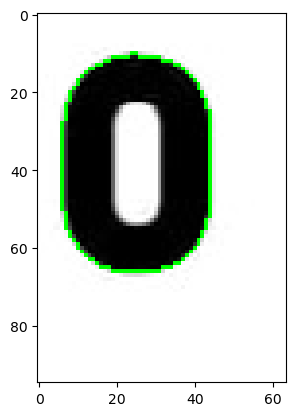

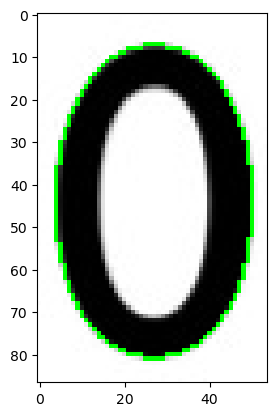

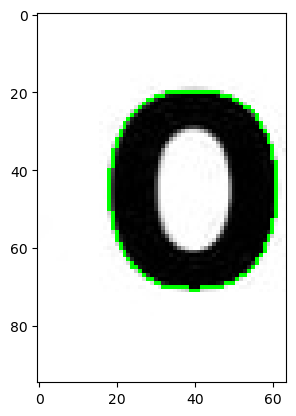

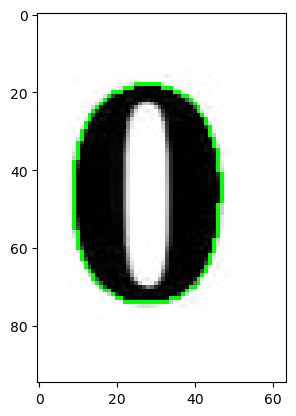

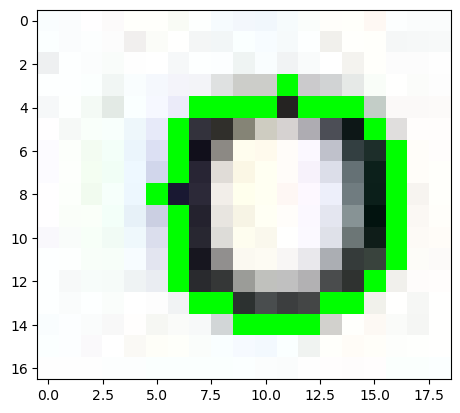

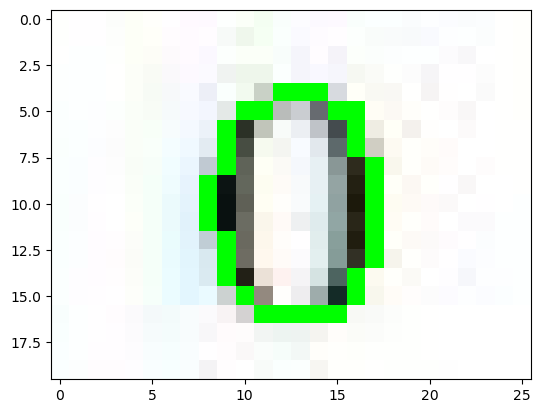

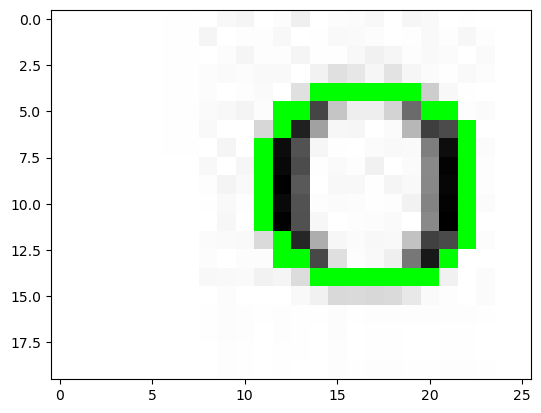

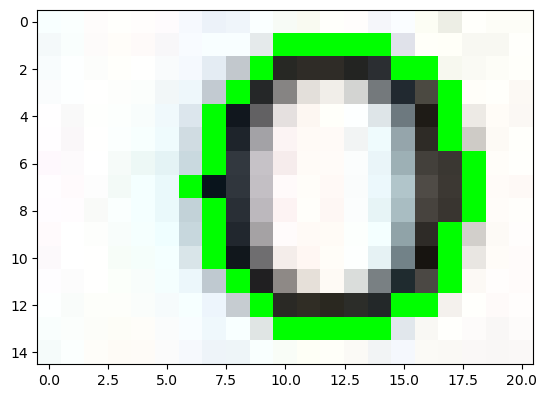

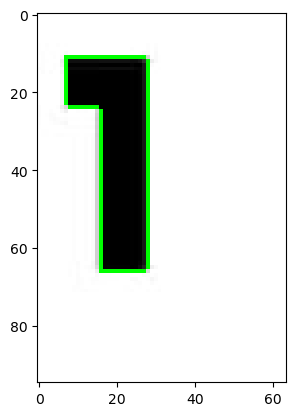

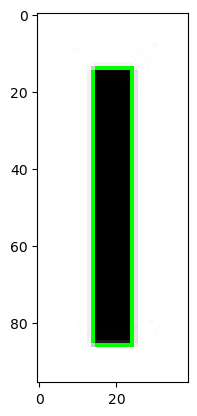

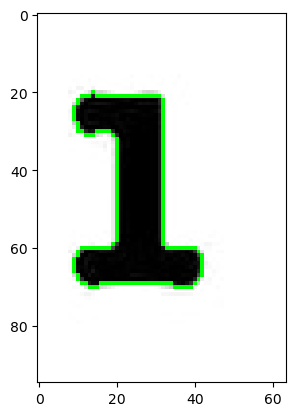

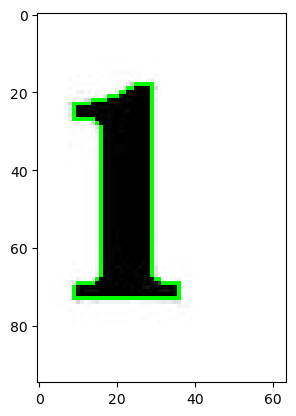

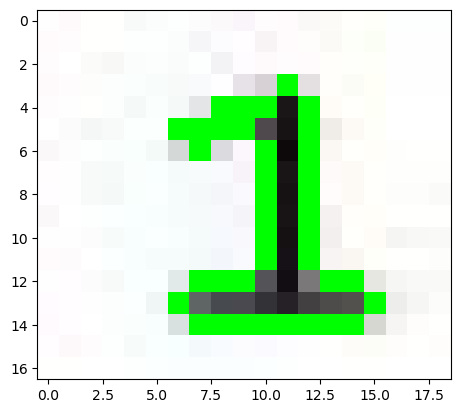

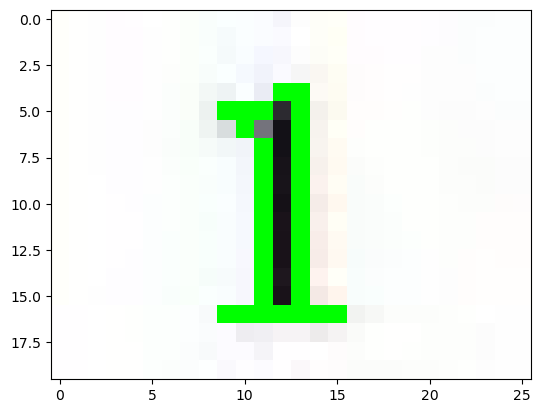

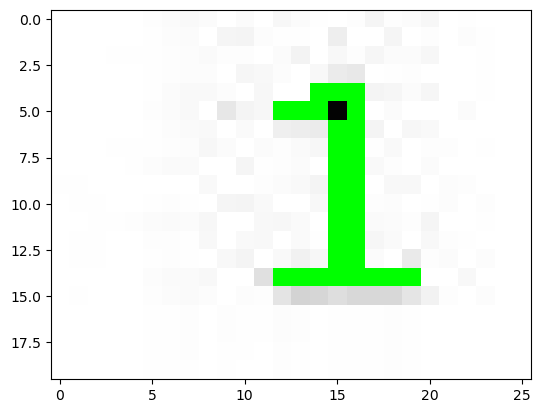

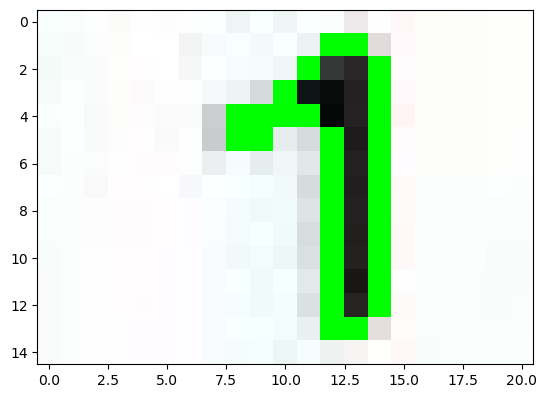

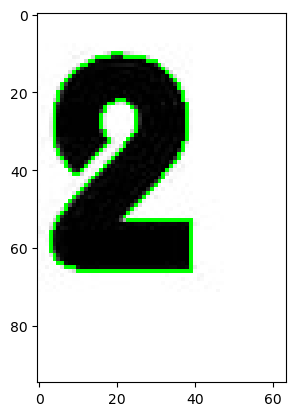

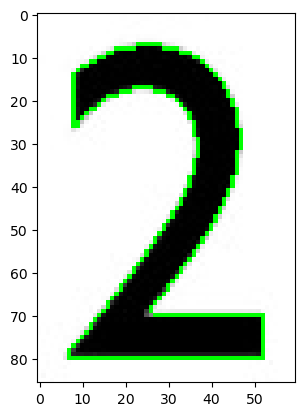

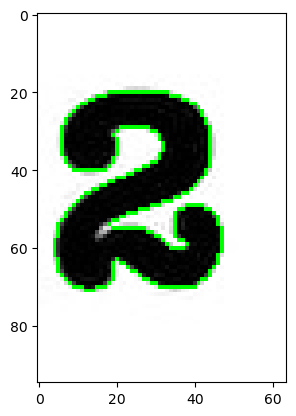

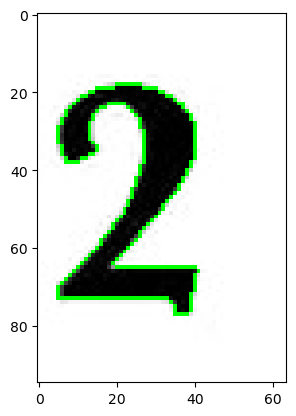

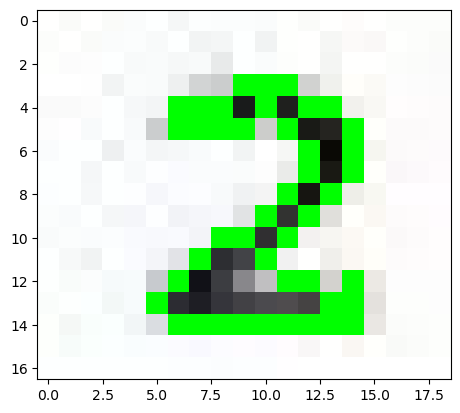

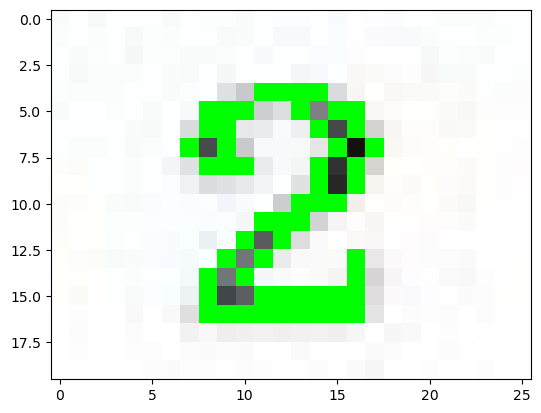

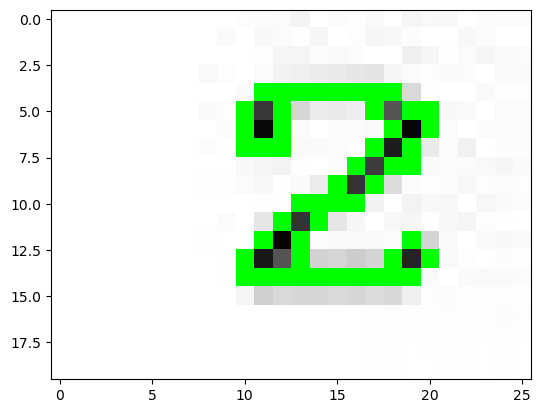

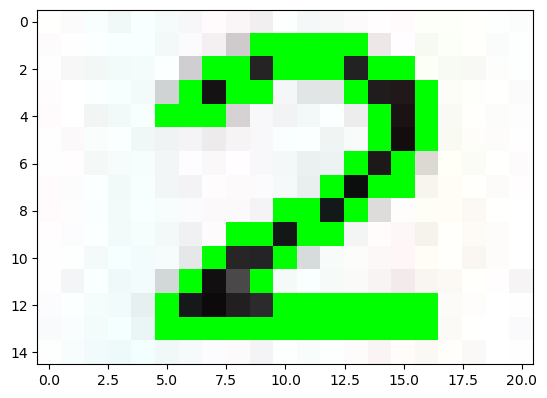

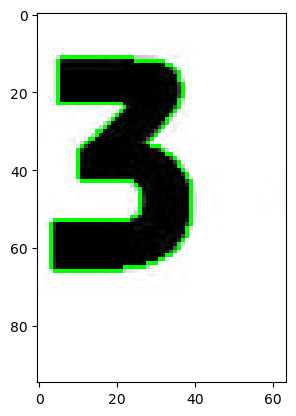

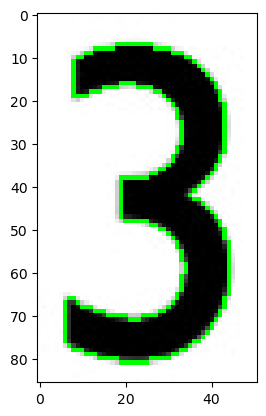

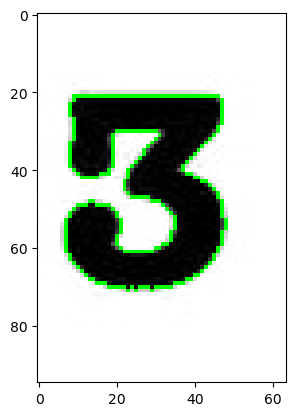

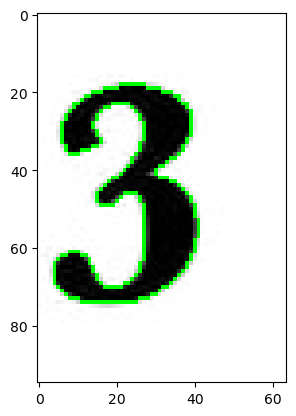

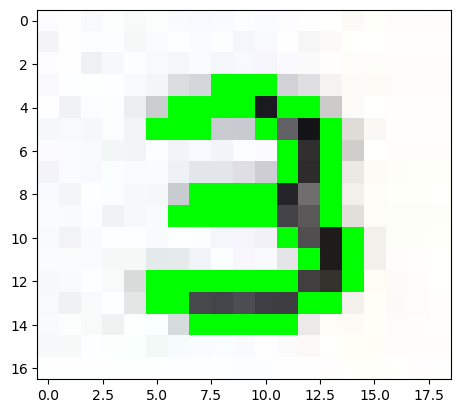

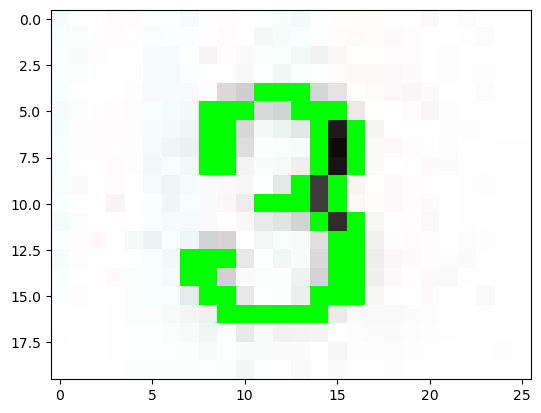

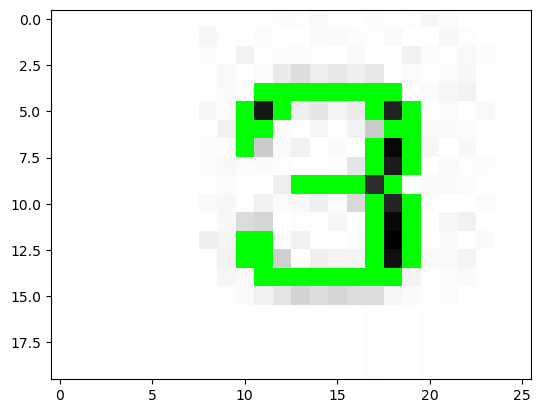

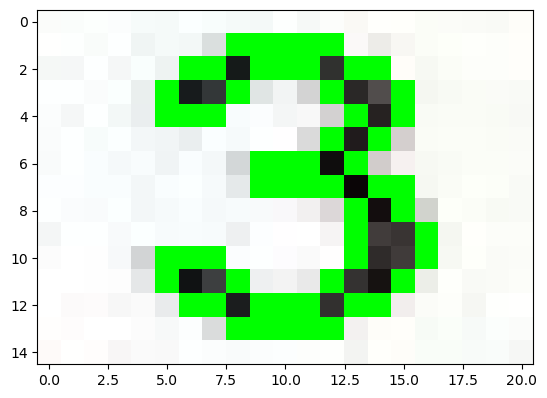

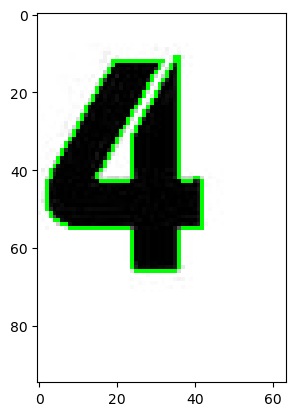

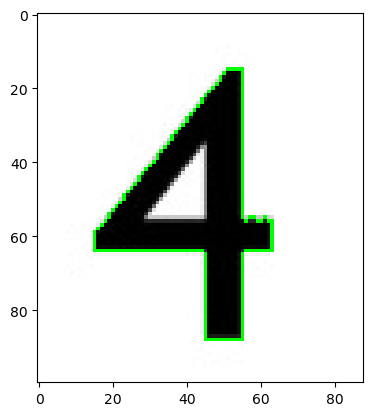

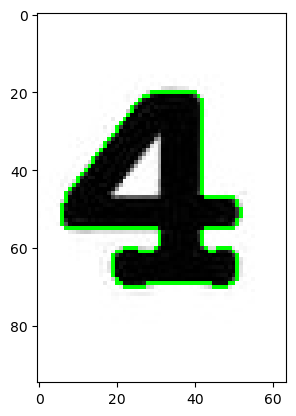

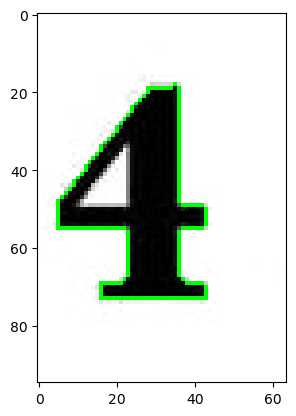

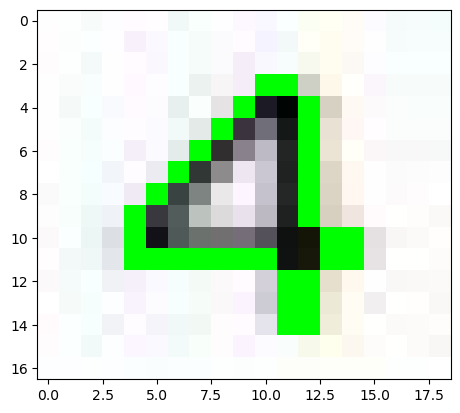

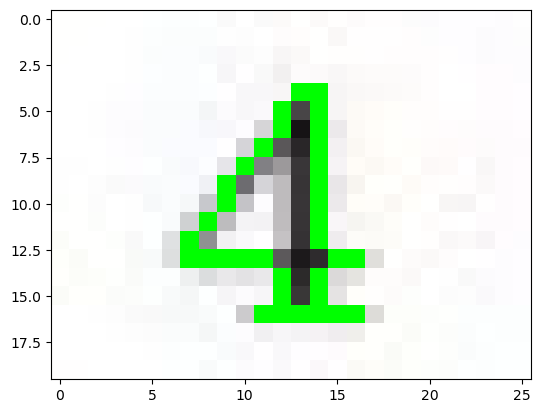

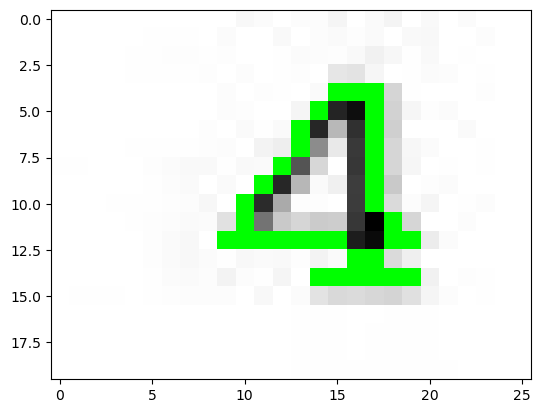

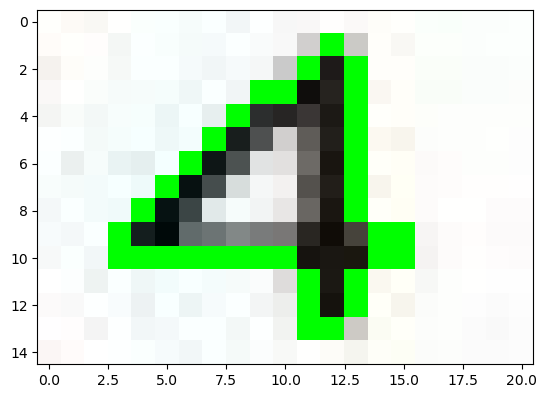

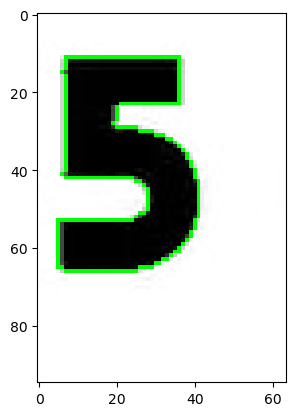

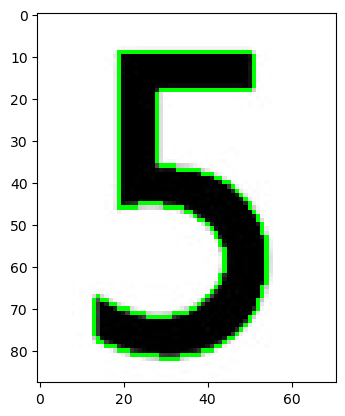

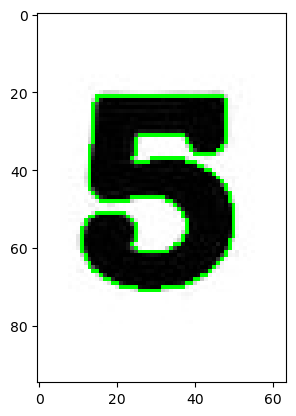

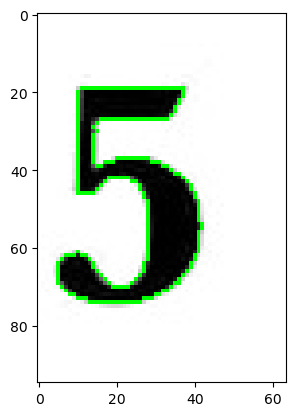

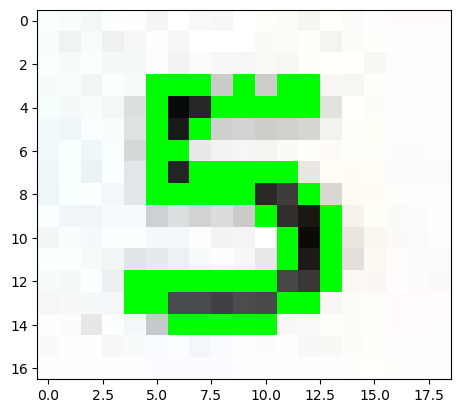

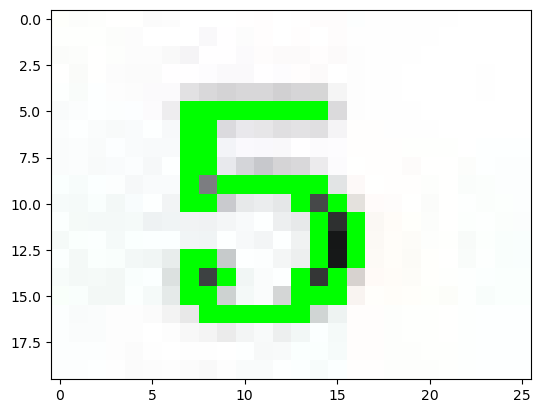

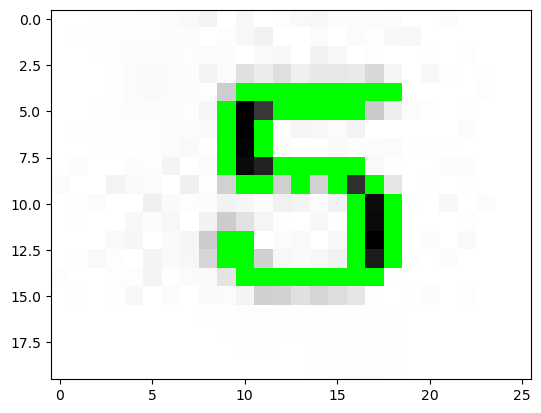

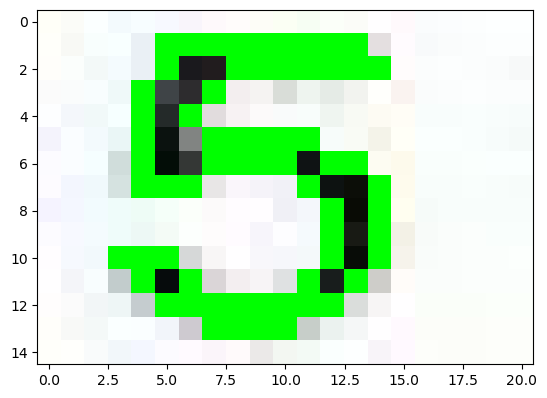

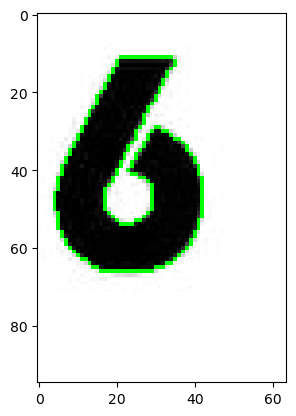

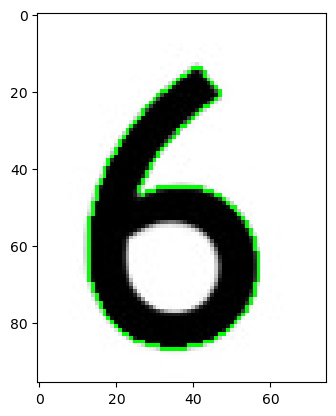

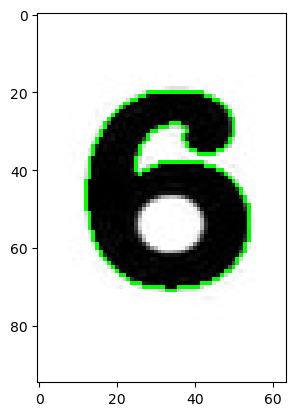

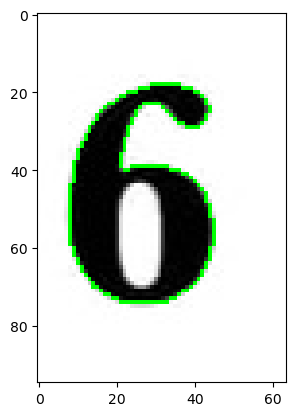

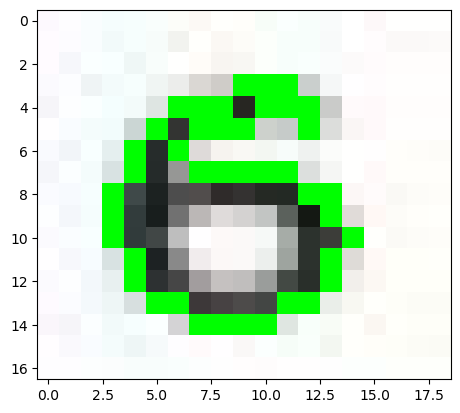

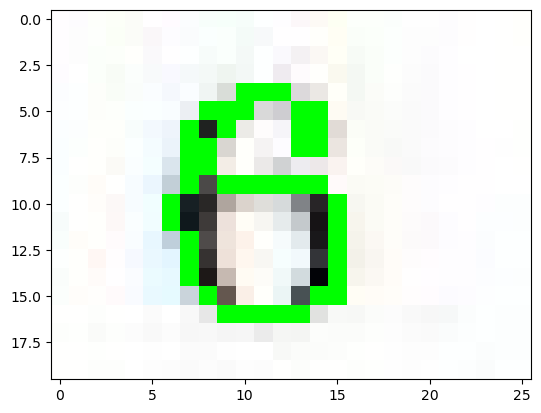

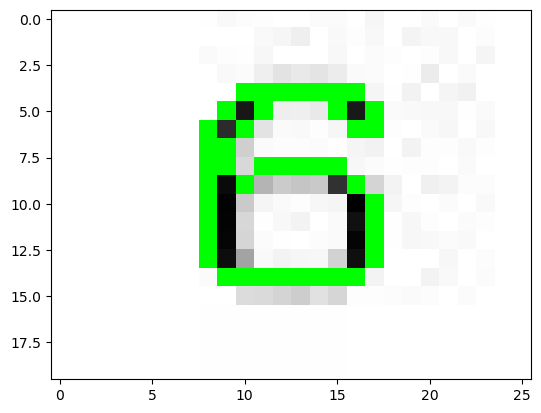

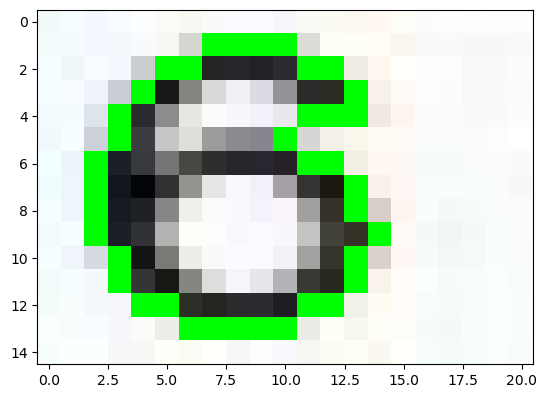

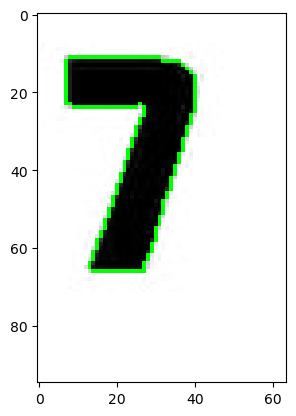

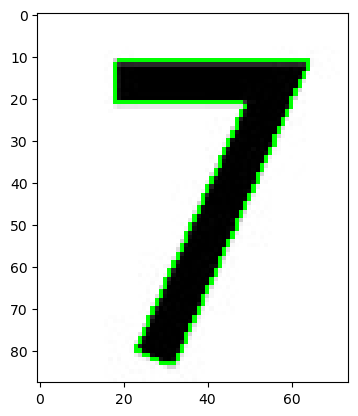

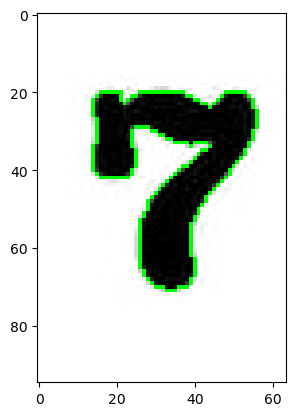

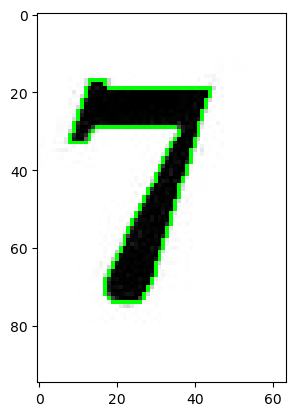

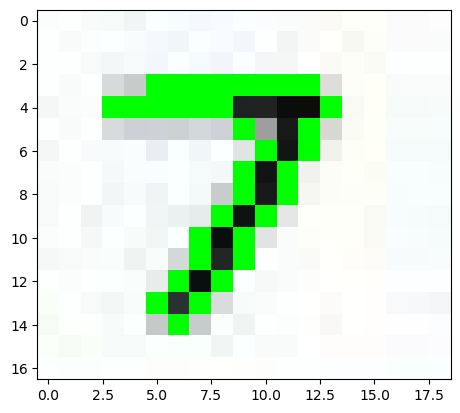

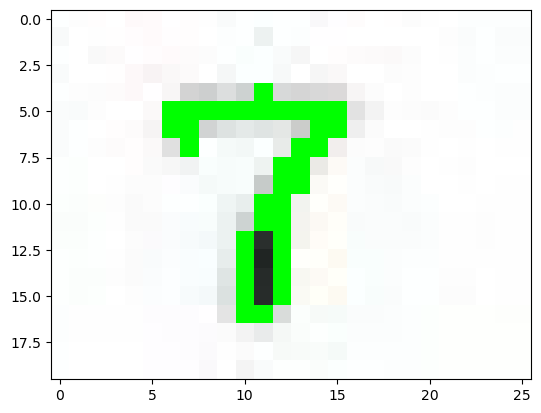

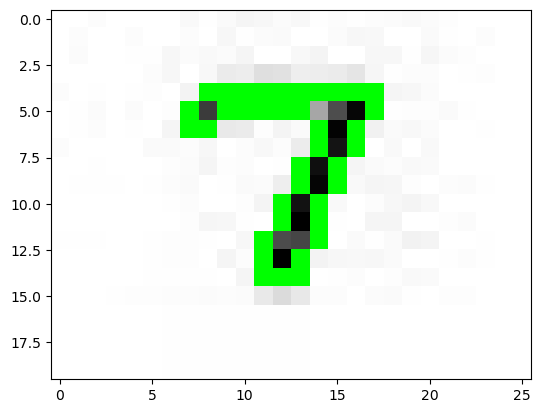

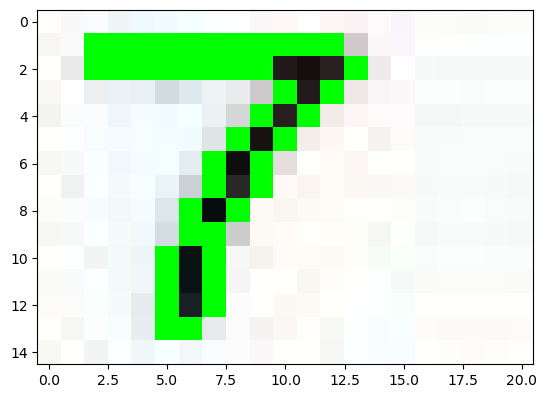

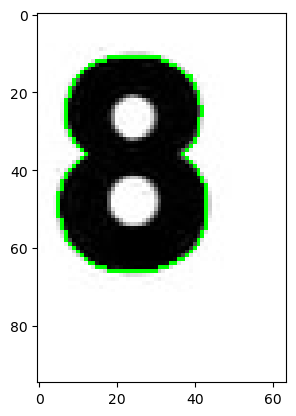

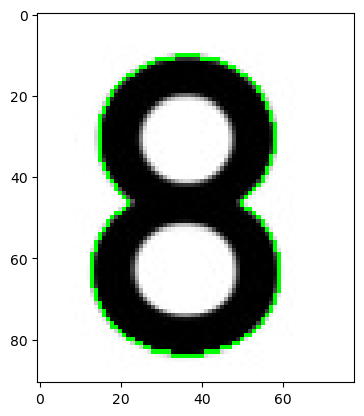

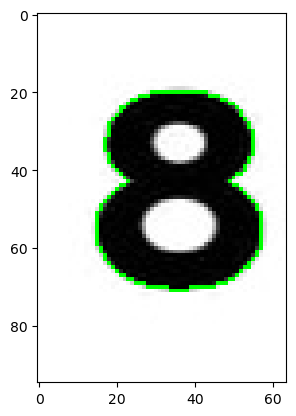

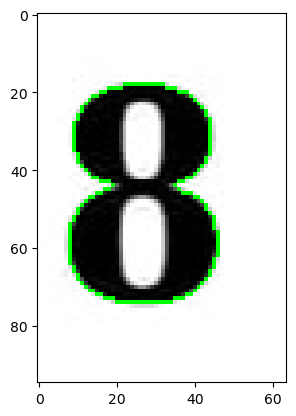

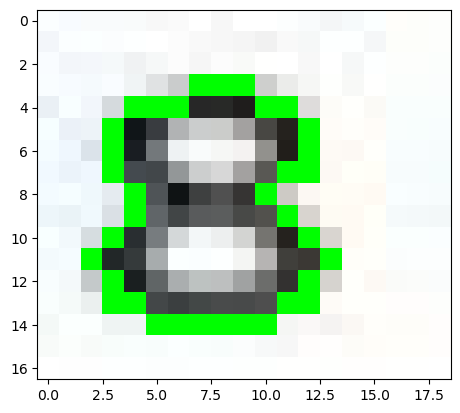

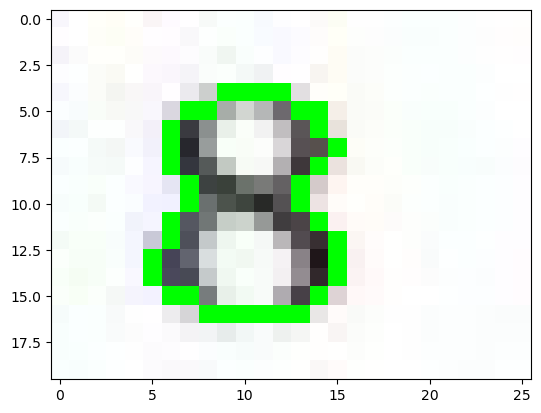

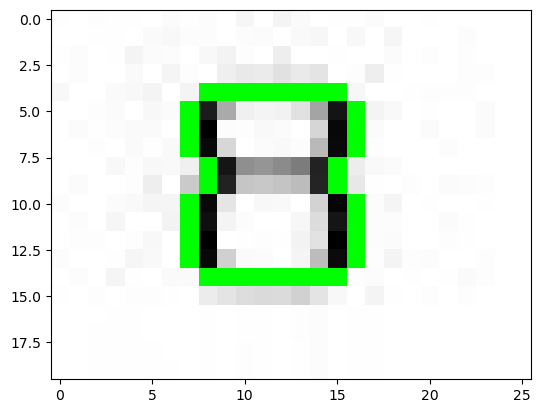

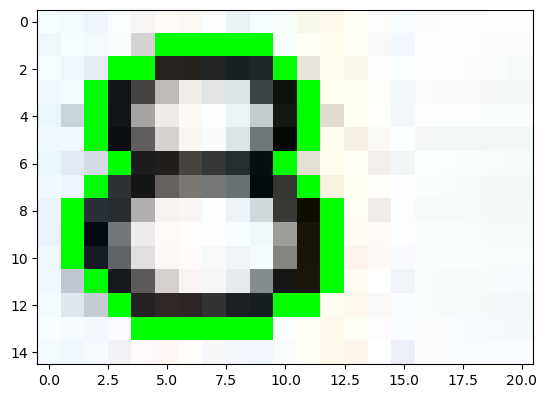

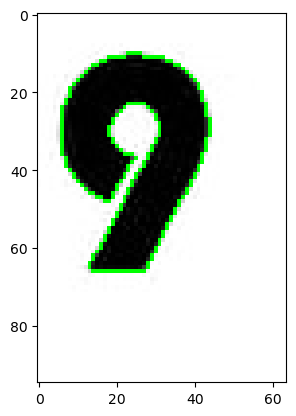

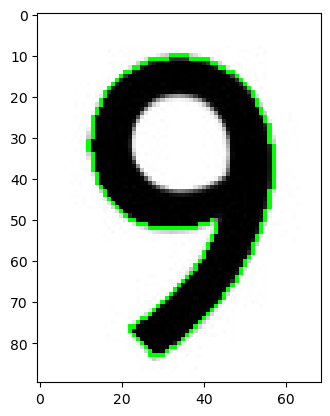

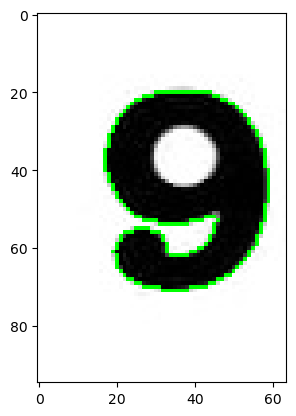

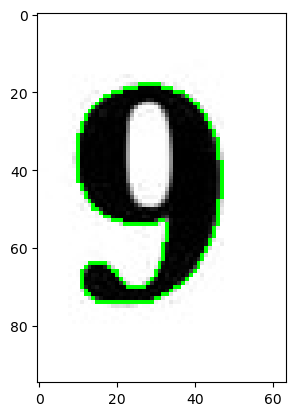

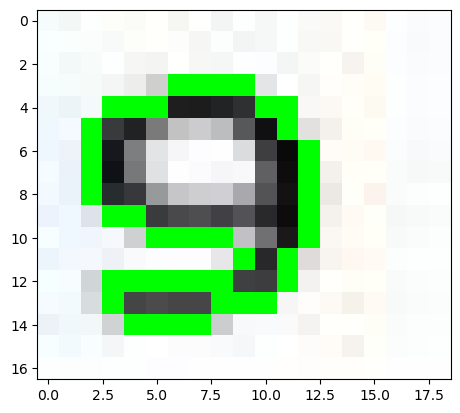

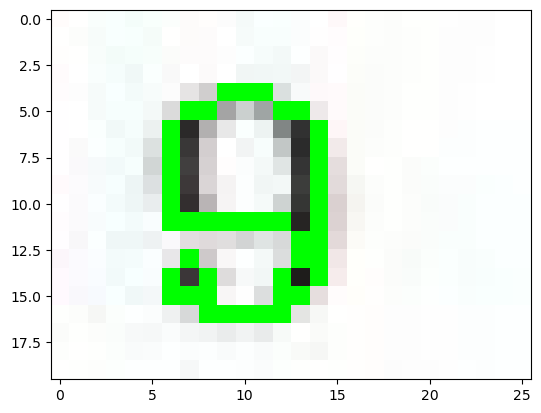

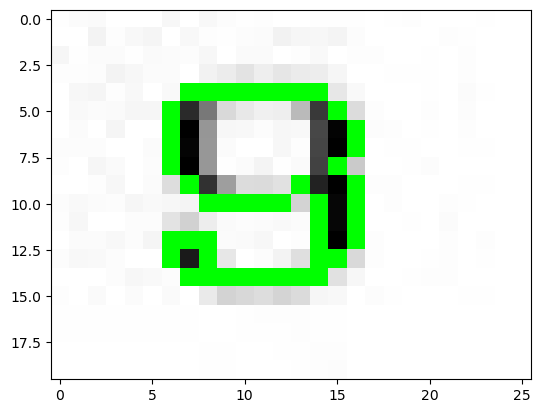

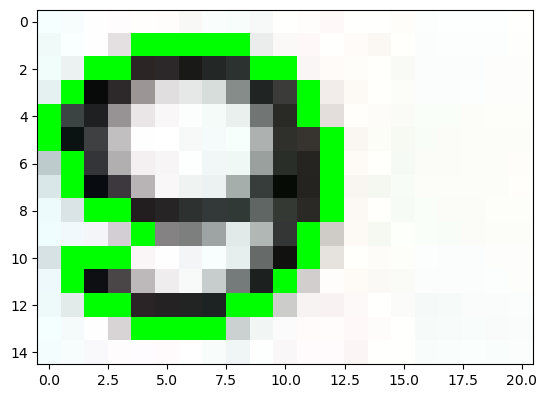

In [21]:
templates = getTemplatesContours()
len(templates)

In [9]:
def calcPicRecall(trueLabels, predictedLabels):
    truePredictions = list((Counter(trueLabels) & Counter(predictedLabels)).elements())
    recall = len(truePredictions)/len(trueLabels)
    return recall

In [10]:
def calcAllRecall(recalls):
    return statistics.mean(recalls)

In [14]:
def predictContour(contour, templates):
    cnt = 0
    acc = 0
    for tmp in templates:
        score = cv2.matchShapes(contour,tmp['contour'],1,0)
        acc +=score
        cnt+=1
        if(cnt==8):
            print(tmp['label'],"avg score",acc/8)
            acc=0
            cnt =0
        

cropped image generated 7 contours
Contour 0
0 avg score 4.215262737698808
1 avg score 3.970107878442423
2 avg score 2.6206715909251495
3 avg score 4.29964742194573
4 avg score 4.046817085172264
5 avg score 4.010059289375141
6 avg score 4.077477753068965
7 avg score 6.15846807791656
8 avg score 4.1266936900674915
9 avg score 4.126603442266975
Contour 1
0 avg score inf
1 avg score inf
2 avg score inf
3 avg score inf
4 avg score inf
5 avg score inf
6 avg score inf
7 avg score inf
8 avg score inf
9 avg score inf
Contour 2
0 avg score 0.023503685888147302
1 avg score 3.109992954094031
2 avg score 2.1295953574116453
3 avg score 2.6625852037439297
4 avg score 0.22826538088188167
5 avg score 2.9491356631717425
6 avg score 0.18126894183624592
7 avg score 5.233389284259254
8 avg score 0.05307079682360222
9 avg score 0.19015454862871328
Contour 3
0 avg score 1.1828382408371367
1 avg score 4.004233652175044
2 avg score 2.2083437977514215
3 avg score 2.7454508238989144
4 avg score 0.91971803802619

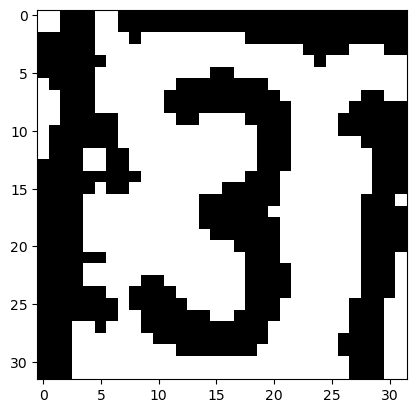

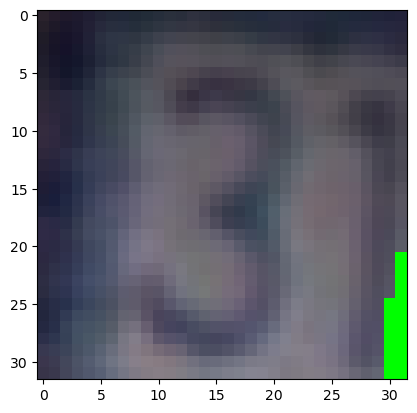

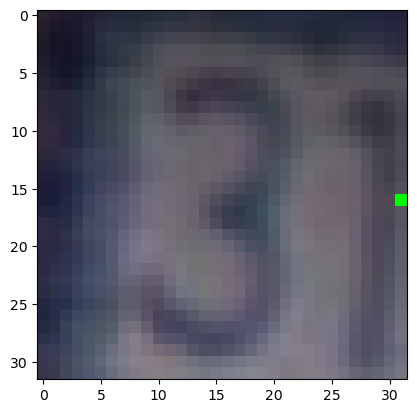

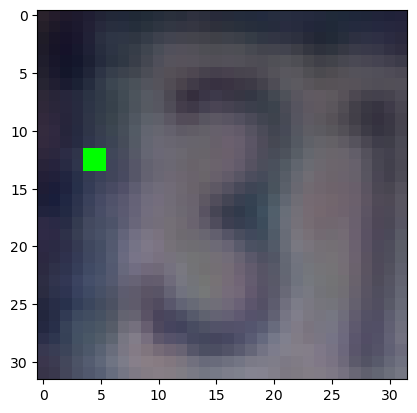

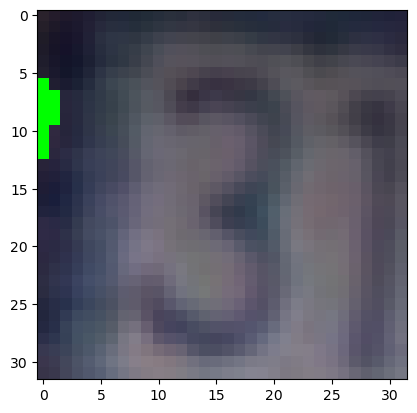

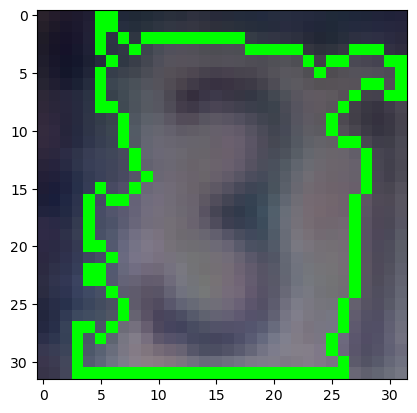

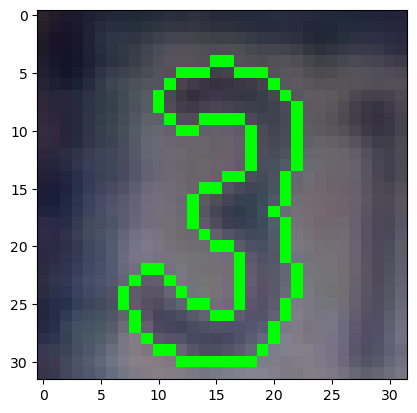

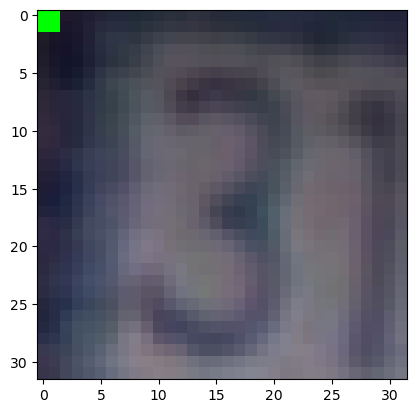

In [15]:
# idx = random.randint(0, len(train_images_all)-1)
idx = 8
trialImage = train_images_cropped_all[idx].copy()
gray = cv2.cvtColor(trialImage, cv2.COLOR_RGB2GRAY)
blurred = cv2.blur(gray,(3,3))
bnr = cv2.adaptiveThreshold(
    blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 1)
contours, hierarchy = cv2.findContours(
    bnr, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
plt.imshow(bnr, cmap='gray')
print("cropped image generated", len(contours), "contours")

i = 0
for cnt in contours:
    print("Contour", i)
    i += 1
    predictContour(cnt, templates)


for j in range(len(contours)):
    tmp = train_images_cropped_all[idx].copy()
    plt.figure()
    toDraw = contours[j]
    cv2.drawContours(image=tmp, contours=[toDraw], contourIdx=-1,
                     color=(0, 255, 0), thickness=1)
    plt.imshow(tmp)
    plt.show()


------------------------------

In [13]:
train_img = train_images_all[80]
train_img = cv2.cvtColor(train_img,cv2.COLOR_BGR2RGB)
train_gray = cv2.cvtColor(train_img,cv2.COLOR_RGB2GRAY)

tmp_img = cv2.imread('Matching/72.jpg')
tmp_img = cv2.cvtColor(tmp_img,cv2.COLOR_BGR2RGB)
tmp_gray = cv2.cvtColor(tmp_img,cv2.COLOR_RGB2GRAY)

# FLANN parameters.
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)

# FLANN based matcher with implementation of k nearest neighbour.
flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(descriptors_train,descriptors_tmp,k=2)

# selecting only good matches.
matchesMask = [[0,0] for i in range(len(matches))]
for i,(m,n) in enumerate(matches):
        if( m.distance < 0.1*n.distance):
            matchesMask[i]=[1,0]
draw_params = dict(matchColor = (0,255,0),
                       singlePointColor = (255,0,0),
                       matchesMask = matchesMask,flags = 0)
     
    # drawing nearest neighbours
result = cv2.drawMatchesKnn(train_img,
                            keypoints_train,
                            tmp_img,
                            keypoints_tmp,
                            matches,
                            None,
                            **draw_params)
plt.imshow(result)
plt.show()

NameError: name 'train_images_all' is not defined

In [ ]:
train_img = train_images_all[80]
train_img = cv2.cvtColor(train_img,cv2.COLOR_BGR2RGB)
train_gray = cv2.cvtColor(train_img,cv2.COLOR_RGB2GRAY)

tmp_img = cv2.imread('Matching/01.jpg')
tmp_img = cv2.cvtColor(tmp_img,cv2.COLOR_BGR2RGB)
tmp_gray = cv2.cvtColor(tmp_img,cv2.COLOR_RGB2GRAY)

sift = cv2.xfeatures2d.SIFT_create()
keypoints_train, descriptors_train = sift.detectAndCompute(train_gray, None)
keypoints_tmp, descriptors_tmp = sift.detectAndCompute(tmp_gray, None)

bf = cv2.BFMatcher()
matches = bf.knnMatch(descriptors_train,descriptors_tmp,k=2)

goodMatches = []
for i,j in matches:
    if (i.distance < 0.95*j.distance):
        goodMatches.append([i])
result_img = cv2.drawMatchesKnn(train_img,keypoints_train,tmp_img,keypoints_tmp,goodMatches[:50],None,flags=2)
plt.imshow(result_img)
plt.show()

NameError: name 'train_images_all' is not defined